# Quantum Kernels & Feature Maps

This notebook follows along and tries to reproduce the main results from [1].

In [1]:
import logging
import sys
from typing import Callable, Dict, List, Optional, Tuple


logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger()
logger.info("Setting up logger for notebook.")

INFO:root:Setting up logger for notebook.


##  Data

In [2]:
import numpy as np
import scipy.stats as ss
import sklearn.datasets
from sklearn.preprocessing import MinMaxScaler


def make_xor(n_samples: int, seed: int, shuffle: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    Makes exclusive OR dataset that has an even split of datapoints in class 0
    and class 1 if n_samples if even; otherwise class 1 will have 1 more datapoint. All X
    values will be in the range -1 to 1.

    Args:
        n_samples (int): number of samples to generate
        seed (int): random seed for data sampling.
        shuffle (bool): shuffle data

    Returns:
        np.ndarray: X, the generated samples
        np.ndarray: y, the labels of the samples (0 or 1)
    """
    # Make labels of half class 0 and half class 1
    class_0_size = int(n_samples/2)
    class_1_size = n_samples - class_0_size
    ys = np.array([0]*class_0_size + [1]*class_1_size)
    
    # Generate x data to have close to even number of datapoints in each corner
    tr_size = int(class_0_size/2)
    bl_size = class_0_size - int(class_0_size/2)
    tl_size = int(class_1_size/2)
    br_size = class_1_size - int(class_1_size/2)
    stds = 1.499

    xs = np.array([
        np.hstack([
            ss.truncnorm.rvs(-stds, stds, loc=0.5, scale=1/3, size=tr_size, random_state=seed),
            ss.truncnorm.rvs(-stds, stds, loc=0.5, scale=1/3, size=bl_size, random_state=seed+1)*-1,
            ss.truncnorm.rvs(-stds, stds, loc=0.5, scale=1/3, size=tl_size, random_state=seed+2)*-1,
            ss.truncnorm.rvs(-stds, stds, loc=0.5, scale=1/3, size=br_size, random_state=seed+3)
        ]),
        np.hstack([
            ss.truncnorm.rvs(-stds, stds, loc=0.5, scale=1/3, size=tr_size, random_state=seed+4),
            ss.truncnorm.rvs(-stds, stds, loc=0.5, scale=1/3, size=bl_size, random_state=seed+5)*-1,
            ss.truncnorm.rvs(-stds, stds, loc=0.5, scale=1/3, size=tl_size, random_state=seed+6),
            ss.truncnorm.rvs(-stds, stds, loc=0.5, scale=1/3, size=br_size, random_state=seed+7)*-1,
        ])
    ]).T

    if shuffle:
        np.random.seed(seed+12)
        shuffle_idxs = np.random.choice(np.arange(n_samples), size=n_samples, replace=False)
        return (xs[shuffle_idxs], ys[shuffle_idxs])
    
    else:
        return (xs, ys)
    
    
def make_exp(n_samples: int, seed: int, shuffle: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    Makes exponential dataset that has an even split of datapoints in class 0
    and class 1 if n_samples if even; otherwise class 1 will have 1 more datapoint. All X
    values will be in the range -1 to 1.

    Args:
        n_samples (int): number of samples to generate
        seed (int): random seed for data sampling.
        shuffle (bool): shuffle data

    Returns:
        np.ndarray: X, the generated samples
        np.ndarray: y, the labels of the samples (0 or 1)
    """
    # Set numpy's random seed
    np.random.seed(seed)

    # Make labels of half class 0 and half class 1
    ys = np.array([0]*int(n_samples/2) + [1]*(n_samples - int(n_samples/2)))

    # Generate x data
    x1s = np.random.random(n_samples)
    x2s = np.empty((n_samples,))

    for idx, y in enumerate(ys):
        exp_boundary = 0.1*(10.33**x1s[idx])
        x2s[idx] = np.random.uniform(0.0001, exp_boundary) if y == 0 else np.random.uniform(exp_boundary, 0.999)

    xs = 2*np.array([x1s,  x2s]).T - 1


    # Return shuffled or ordered data
    if shuffle:
        np.random.seed(seed+15)
        shuffle_idxs = np.random.choice(np.arange(n_samples), size=n_samples, replace=False)
        return (xs[shuffle_idxs], ys[shuffle_idxs])
    
    else:
        return (xs, ys)


def make_circles(n_samples: int, seed: int, shuffle: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    Make circles dataset that has an even split of datapoints in class 0 and class 1 if n_samples
    is even; otherwise class 1 will have 1 more datapoint. All X values will be in the range
    -1 to 1.

    Args:
        n_samples (int): number of samples to generate
        seed (int): random seed for data sampling
        shuffle (bool, optional): shuffle data. Defaults to True.

    Returns:
        np.ndarray: X, the generated samples
        np.ndarray: y, the labels of the samples (0 or 1)
    """
    # Generate data
    X, y = sklearn.datasets.make_circles(
        n_samples=n_samples, factor=0.4, noise=0.1, random_state=seed, shuffle=shuffle
    )

    # Scale the x data because the noise can move it outside the (-1, 1) range
    X_scaled = MinMaxScaler(feature_range=(-0.999, 0.999)).fit_transform(X)

    return X_scaled, y


def make_moons(n_samples: int, seed: int, shuffle: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    Make moons dataset that has an even split of datapoints in class 0 and class 1 if n_samples
    is even; otherwise class 1 will have 1 more datapoint. All X values will be in the range
    -1 to 1.

    Args:
        n_samples (int): number of samples to generate
        seed (int): random seed for data sampling
        shuffle (bool, optional): shuffle data. Defaults to True.

    Returns:
        np.ndarray: X, the generated samples
        np.ndarray: y, the labels of the samples (0 or 1)
    """
    # Generate data
    X, y = sklearn.datasets.make_moons(
        n_samples=n_samples, noise=0.13, random_state=seed, shuffle=shuffle
    )

    # Scale the x data because the noise can move it outside the (-1, 1) range
    X_scaled = MinMaxScaler(feature_range=(-0.999, 0.999)).fit_transform(X)

    return X_scaled, y

In [3]:
from sklearn.model_selection import train_test_split

def make_datasets(n_samples: int, training_pct: Optional[float] = None, seed: Optional[int] = None) -> Dict:
    """
    Creates the 4 datasets (circles, moons, exp, and xor) which consist of n_samples of 2-dimensional X data
    and the corresponding binary classification labels as y. If `training_pct` is None, X and y data is
    returned for each dataset; otherwise, the datasets returned are split into 'train' and 'test' partitions
    based on the training/test split percentage. 

    Args:
        n_samples (int): number of samples to generate from each dataset distribution
        training_pct (Optional[float], optional): Training/test split percentage. Defaults to None.
        seed (Optional[int], optional): Random seed for the data sampling. Defaults to Optional[int]=None.

    Returns:
        Dict: dictionary of the datasets
    """
    # Make datasets
    circles = make_circles(n_samples=n_samples, seed=seed)
    moons = make_moons(n_samples=n_samples, seed=seed)
    xor = make_xor(n_samples=n_samples, seed=seed)
    exp = make_exp(n_samples=n_samples, seed=seed)

    if training_pct is None:
        ds = {
            'circles': {'X': circles[0], 'y': circles[1]},
            'exp': {'X': exp[0], 'y': exp[1]},
            'moons': {'X': moons[0], 'y': moons[1]},
            'xor': {'X': xor[0], 'y': xor[1]}
        }

    else:
        c_X_train, c_X_test, c_y_train, c_y_test = train_test_split(
            circles[0], circles[1], test_size=(1-training_pct), random_state=42, stratify=circles[1]
        )
        e_X_train, e_X_test, e_y_train, e_y_test = train_test_split(
            exp[0], exp[1], test_size=(1-training_pct), random_state=42, stratify=exp[1]
        )
        m_X_train, m_X_test, m_y_train, m_y_test = train_test_split(
            moons[0], moons[1], test_size=(1-training_pct), random_state=42, stratify=moons[1]
        )
        x_X_train, x_X_test, x_y_train, x_y_test = train_test_split(
            xor[0], xor[1], test_size=(1-training_pct), random_state=42, stratify=xor[1]
        )
        ds = {
            'circles': {'train': {'X': c_X_train, 'y': c_y_train}, 'test': {'X': c_X_test, 'y': c_y_test}},
            'exp': {'train': {'X': e_X_train, 'y': e_y_train}, 'test': {'X': e_X_test, 'y': e_y_test}},
            'moons': {'train': {'X': m_X_train, 'y': m_y_train}, 'test': {'X': m_X_test, 'y': m_y_test}},
            'xor': {'train': {'X': x_X_train, 'y': x_y_train}, 'test': {'X': x_X_test, 'y': x_y_test}}
        }

    return ds

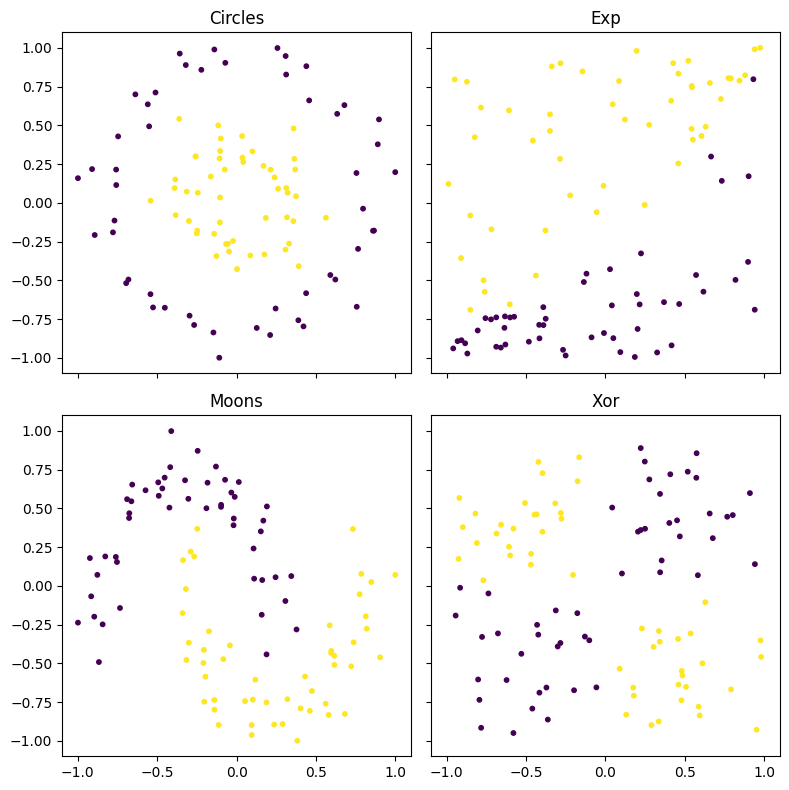

In [4]:
import matplotlib.pyplot as plt


toy_dataset = make_datasets(n_samples=100, seed=42)
DATASET_NAMES = list(toy_dataset.keys())

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharex=True, sharey=True)
axs[0, 0].scatter(toy_dataset['circles']['X'][:, 0], toy_dataset['circles']['X'][:, 1], c=toy_dataset['circles']['y'], s=10)
axs[0, 1].scatter(toy_dataset['exp']['X'][:, 0], toy_dataset['exp']['X'][:, 1], c=toy_dataset['exp']['y'], s=10)
axs[1, 0].scatter(toy_dataset['moons']['X'][:, 0], toy_dataset['moons']['X'][:, 1], c=toy_dataset['moons']['y'], s=10)
axs[1, 1].scatter(toy_dataset['xor']['X'][:, 0], toy_dataset['xor']['X'][:, 1], c=toy_dataset['xor']['y'], s=10)
axs[0, 0].set_title('Circles')
axs[0, 1].set_title('Exp')
axs[1, 0].set_title('Moons')
axs[1, 1].set_title('Xor')

plt.tight_layout()
plt.show()

## Encoding Functions

Now we'll implement different quantum feature maps based on the set of encoding functions given in [1], listed below:

1. $\phi_1(\bm{x}) = x_1, \phi_2(\bm{x}) = x_2, \phi_{1,2}(\bm{x}) = \pi x_1x_2$<br><br>
2. $\phi_1(\bm{x}) = x_1, \phi_2(\bm{x}) = x_2, \phi_{1,2}(\bm{x}) = \frac{\pi}{2}(1-x_1)(1-x_2)$<br><br>
3. $\phi_1(\bm{x}) = x_1, \phi_2(\bm{x}) = x_2, \phi_{1,2}(\bm{x}) = exp(\frac{|x_1 - x_2|^2}{8/ln(\pi)})$<br><br>
4. $\phi_1(\bm{x}) = x_1, \phi_2(\bm{x}) = x_2, \phi_{1,2}(\bm{x}) = \frac{\pi}{3cos(x_1)cos(x_2)}$<br><br>
5. $\phi_1(\bm{x}) = x_1, \phi_2(\bm{x}) = x_2, \phi_{1,2}(\bm{x}) = \pi cos(x_1)cos(x_2)$<br><br>

We'll set up a mapping (dictionary) of our feature map functions below so we can easily loop through all of them for each of our experiments.

In [5]:
from math import pi

# Dictionary of encoding functions that returns function of x1 and x2
encoding_fns = {
    'encoding_fn_1': lambda x1, x2: pi*x1*x2,
    'encoding_fn_2': lambda x1, x2: (pi/2)*(1-x1)*(1-x2),
    'encoding_fn_3': lambda x1, x2: np.exp(((x1-x2)*(x1-x2))/(8/np.log(pi))),
    'encoding_fn_4': lambda x1, x2: (pi)/(3*np.cos(x1)*np.cos(x2)),
    'encoding_fn_5': lambda x1, x2: pi*np.cos(x1)*np.cos(x2)
}

## Paramaterized Quantum Circuit

Now we need to set up a parameterized quantum circuit to implement our custom feature map. Following [1], we will build a 2-qubit circuit composed on 3 phase shift gates and 2 CNOT gates. When we actually use this circuit to compute our kernel functions, we will bind our actual data values.

In [6]:
from qiskit.circuit.library import PauliFeatureMap
from functools import partial

def param_circuit(encoding_fn: Callable) -> PauliFeatureMap:
    """
    Returns a PauliFeatureMap parameterized quantum circuit that encodes
    the given encoding function.

    Args:
        encoding_fn (Callable): encoding function of signiture (x1, x2) -> x_1,2

    Returns:
        PauliFeatureMap: feature map
    """
    # First define a custom data map based off a given encoding function
    def custom_data_map_func(func, x):
        coeff = x[0] if len(x) == 1 else func(x[0], x[1])
        return coeff

    # Then use the partial function to freeze the encoding function
    data_map_func = partial(custom_data_map_func, encoding_fn)
    return PauliFeatureMap(feature_dimension=2, reps=2, entanglement='linear', alpha=1.0, data_map_func=data_map_func)

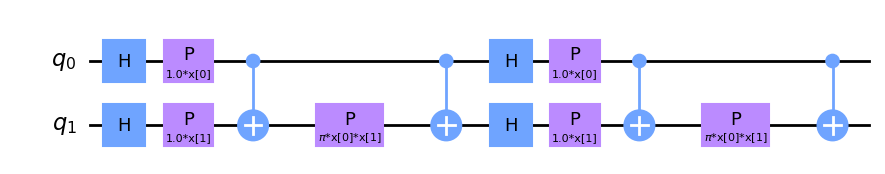

In [7]:
param_circuit(encoding_fn=encoding_fns['encoding_fn_1']).decompose().draw()

## Quantum Kernel Setup

The last thing we need to setup is a function that will actually compute our kernel matrices given the quantum circuit, a feature map function, and data. We can set this up as shown below such that we can pass everything in as an argument which makes it easy to run for either test or training data, for each feature map, and for each dataset.

In [8]:
from qiskit import opflow

# Qiskit code throws deprecation warning when we use the calculate_kernel_old function
import warnings
warnings.filterwarnings('ignore')


## This function is now deprecated due to the deprecation of opflow.
def calculate_kernel_old(
        feature_map: PauliFeatureMap, train_X: np.ndarray, test_X: Optional[np.ndarray] = None
    ) -> np.ndarray:
    """
    Calculates the kernel matrix given the feature map and training and/or testing data.
    If only training data is provided, it computes the inner product of the training data with itself;
    otherwise it computes the fidelities between the training and testing data.

    Args:
        feature_map (PauliFeatureMap): PauliFeatureMap / Quantum circuit of the feature map
        train_X (np.ndarray): training data array, M x N, where M is the number of samples
            and N is the number of features
        test_X (Optional[np.ndarray], optional): test data array, M x N, where M is the
            number of test samples and N is the number of features. Defaults to None.

    Returns:
        np.ndarray: kernel matrix
    """
    # If no test data is provided, then calculate inner product of training data
    # with self. Otherwise, calculate inner products of test data with training
    if test_X is None:
        test_X = train_X

    # Use Operator Flow to create a list of feature map circuits,
    # parameterized by each data point
    train_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(train_X).tolist()))
        )
    test_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(test_X).tolist()))
        )
    
    # Compute the square of the conjugate inner product of the feature
    # map circuits: the kernel matrix
    kernel = np.abs(
        (~test_circuits.to_matrix_op() @ train_circuits.to_matrix_op()).eval()
    )**2
    
    return kernel

/var/folders/f6/glc4hjkn44gg3qtb6mq_88kc0000gq/T/ipykernel_54098/2264021944.py:1: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit import opflow


In [9]:
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# New implementation using the new FidelityQuantumKernel class which
# reproduces the exact results of the 'calculate_kernel_old' function
def calculate_kernel(
        feature_map: PauliFeatureMap,
        train_X: np.ndarray,
        test_X: Optional[np.ndarray] = None,
        shots: Optional[int] = None,
        sampler_seed: Optional[int] = None,
        backend: str = 'qasm_simulator'
    ) -> np.ndarray:
    """
    Simulates or calculates the kernel matrix given the feature map and training and/or testing data.
    If only training data is provided, it computes the inner product of the training data with itself;
    otherwise it computes the fidelities between the training and testing data. If `shots` is None, 
    then it calculates the probabilities. Otherwise, it samples the number of `shots` from the multinomial
    distribution to compute the kernel matrix.

    Args:
        feature_map (PauliFeatureMap): PauliFeatureMap / Quantum circuit of the feature map
        train_X (np.ndarray): training data array, M x N, where M is the number of samples
            and N is the number of features
        test_X (Optional[np.ndarray], optional): test data array, M x N, where M is the
            number of test samples and N is the number of features. Defaults to None.
        shots (Optional[int], optional): Number of shots for the sampler. If none is provided,
            then it computes the probabilities. Defaults to None.
        sampler_seed (Optional[int], optional): Random seed for the sampler; is ignored if
            `shots` is None. Defaults to None.
        backend (str, optional): Quantum backend to use. Defaults to 'qasm_simulator'.

    Returns:
        np.ndarray: kernel matrix
    """
    sampler = Sampler(options=dict(shots=shots, seed=sampler_seed, backend=backend))
    fidelity = ComputeUncompute(sampler=sampler)
    adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

    if test_X is None:
        kernel = adhoc_kernel.evaluate(x_vec=train_X)
    else:
        # Note that when passing both training & testing data, your TESTING data now becomes
        # the new x_vec argument and your training data is passed as y_vec. If reversed, your
        # kernel matrix will be transposed
        kernel = adhoc_kernel.evaluate(x_vec=test_X, y_vec=train_X)
    
    return kernel

## Calculations & Results

The code below will actually run our computations all the way through and store the results in our variables above. This process will first compute our kernel matrices and then pass those values to the (classical) scikit-learn support vector machine model to fit. Then it is scored on our training data and testing data and the accuracy results are saved. The paper's method runs through this on a datset with 20 datapoints 5 times (5 cross fold validation). However, I will repeat for 30 in order to validate the statistical significance of the results obtained.

In [10]:
import xarray as xr
from sklearn.svm import SVC

# Store results
cv_num = 30
results_train = np.empty((cv_num, len(DATASET_NAMES), len(encoding_fns)))
results_test = np.empty((cv_num, len(DATASET_NAMES), len(encoding_fns)))

# Define all the settings for running this exactly as the paper (except random seeds)
training_pct = 0.5
N = 40
c = 10e10 # this implements hard-margin SVM but could be overfitting
data_seed = 112120231
sampler_seed = 112120232
shots = 10000
backend='qasm_simulator'


for cv_id in np.arange(cv_num):
    logger.info(f"Training models for cross fold validation {cv_id}")

    datasets = make_datasets(n_samples=N, training_pct=training_pct, seed=data_seed+cv_id)
    for ef_idx, encoding_fn in enumerate(encoding_fns.values()):
        for ds_idx, dataset in enumerate(datasets):
            # First, precompute our kernels
            feature_map = param_circuit(encoding_fn)

            train_kernel = calculate_kernel(
                feature_map=feature_map,
                train_X=datasets[dataset]['train']['X'],
                shots=shots,
                sampler_seed=sampler_seed,
                backend=backend
            )
            test_kernel = calculate_kernel(
                feature_map=feature_map,
                train_X=datasets[dataset]['train']['X'],
                test_X=datasets[dataset]['test']['X'],
                shots=shots,
                sampler_seed=sampler_seed,
                backend=backend
            )

            # Then fit our support vector classifier
            model = SVC(kernel='precomputed', C=c)
            model = model.fit(train_kernel, datasets[dataset]['train']['y'])

            # Lastly, score our training accuracy and test accuracy and store results
            train_acc = model.score(train_kernel, datasets[dataset]['train']['y'])
            test_acc = model.score(test_kernel, datasets[dataset]['test']['y'])
            results_train[cv_id][ds_idx][ef_idx] = train_acc
            results_test[cv_id][ds_idx][ef_idx] = test_acc

results_ds = xr.Dataset(
    data_vars={
        "train":(["cv_id", "dataset", "feature_map"], results_train),
        "test": (["cv_id", "dataset", "feature_map"], results_test)
    },
    coords={"cv_id": np.arange(cv_num), "dataset": DATASET_NAMES, "feature_map": list(encoding_fns.keys())},
    attrs={"n_samples": N, "training_pct": training_pct}
).transpose("cv_id", "feature_map", "dataset")

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:root:Training models for cross fold validation 0
INFO:root:Training models for cross fold validation 1
INFO:root:Training models for cross fold validation 2
INFO:root:Training models for cross fold validation 3
INFO:root:Training models for cross fold validation 4
INFO:root:Training models for cross fold validation 5
INFO:root:Training models for cross fold validation 6
INFO:root:Training models for cross fold validation 7
INFO:root:Training models for cross fold validation 8
INFO:root:Training models for cross fold validation 9
INFO:root:Training models for cross fold validation 10
INFO:root:Training models for cross fold validation 11
INFO:root:Training models for cross fold validation 12
INFO:root:Training models for cross fold validation 13
INFO:root:Training models for cross fold validation 14
INFO:root:Trainin

In [11]:
# Training results
results_ds.mean("cv_id").train.to_pandas()

dataset,circles,exp,moons,xor
feature_map,,,,
encoding_fn_1,1.0,1.0,1.0,1.0
encoding_fn_2,1.0,1.0,1.0,1.0
encoding_fn_3,1.0,1.0,1.0,1.0
encoding_fn_4,1.0,1.0,1.0,1.0
encoding_fn_5,1.0,1.0,1.0,1.0


In [12]:
# Test results
results_ds.mean("cv_id").test.to_pandas()

dataset,circles,exp,moons,xor
feature_map,,,,
encoding_fn_1,0.938333,0.786667,0.683333,0.930000
encoding_fn_2,0.871667,0.790000,0.830000,0.848333
encoding_fn_3,0.970000,0.893333,0.700000,0.911667
encoding_fn_4,0.973333,0.853333,0.853333,0.871667
encoding_fn_5,0.973333,0.835000,0.883333,0.856667


In [13]:
# Standard deviation of the cross fold validation results
results_ds.std("cv_id").test.to_pandas()

dataset,circles,exp,moons,xor
feature_map,,,,
encoding_fn_1,0.077118,0.100775,0.086923,0.043970
encoding_fn_2,0.080295,0.119304,0.098826,0.082141
encoding_fn_3,0.062716,0.089194,0.107238,0.066687
encoding_fn_4,0.049554,0.099107,0.094810,0.081326
encoding_fn_5,0.051208,0.087702,0.076739,0.082395


In [14]:
# Display the encodidng functions that perform the max for each dataset
results_ds.test.mean("cv_id").idxmax("feature_map").to_pandas()

dataset
circles    encoding_fn_4
exp        encoding_fn_3
moons      encoding_fn_5
xor        encoding_fn_1
dtype: object

In [15]:
# Display the average accuracies across all feature maps per dataset
results_ds.test.mean(["cv_id", "feature_map"]).to_pandas()

dataset
circles    0.945333
exp        0.831667
moons      0.790000
xor        0.883667
dtype: float64

## Statistical Results Analysis

The paper makes some claims about which encoding functions / feature maps perform better on which dataset so this section will statistically analyze that claim to see if there is significance in the accuracies achieved by the different kernels. First we will do an ANOVA test on the sets of 30 cross fold validation accuracies obtained by each feature map for a dataset to see if we see equal means/variances or if one stands out. We are assuming, under the law of large numbers that our cross fold validations accuraces form a normal distribution about the true mean, the datapoints are independent, and that the variances are about equal.

In [16]:
import pandas as pd

# Store anova results
anova_results = np.empty((len(DATASET_NAMES), 2))

# first lets do the anova test for each dataset
for ds_idx, dataset in enumerate(DATASET_NAMES):
    samples = [results_ds.test.sel(dataset=dataset, feature_map=feature_map) for feature_map in list(encoding_fns.keys())]
    f_stat, pval = ss.f_oneway(*samples)
    anova_results[ds_idx][0] = f_stat
    anova_results[ds_idx][1] = pval


# set significant level
alpha = 0.05

anova_results_df = pd.DataFrame(anova_results, index=DATASET_NAMES, columns=['F Statistic', 'P-value'])
anova_results_df['Significant?'] = anova_results_df['P-value'] < alpha
anova_results_df

,F Statistic,P-value,Significant?
circles,12.958928,4.782798e-09,True
exp,5.848794,2.160351e-04,True
moons,28.037757,2.978558e-17,True
xor,6.903099,4.090262e-05,True


Let's now loop through each dataset and do a pairwise comparison of each feature map.

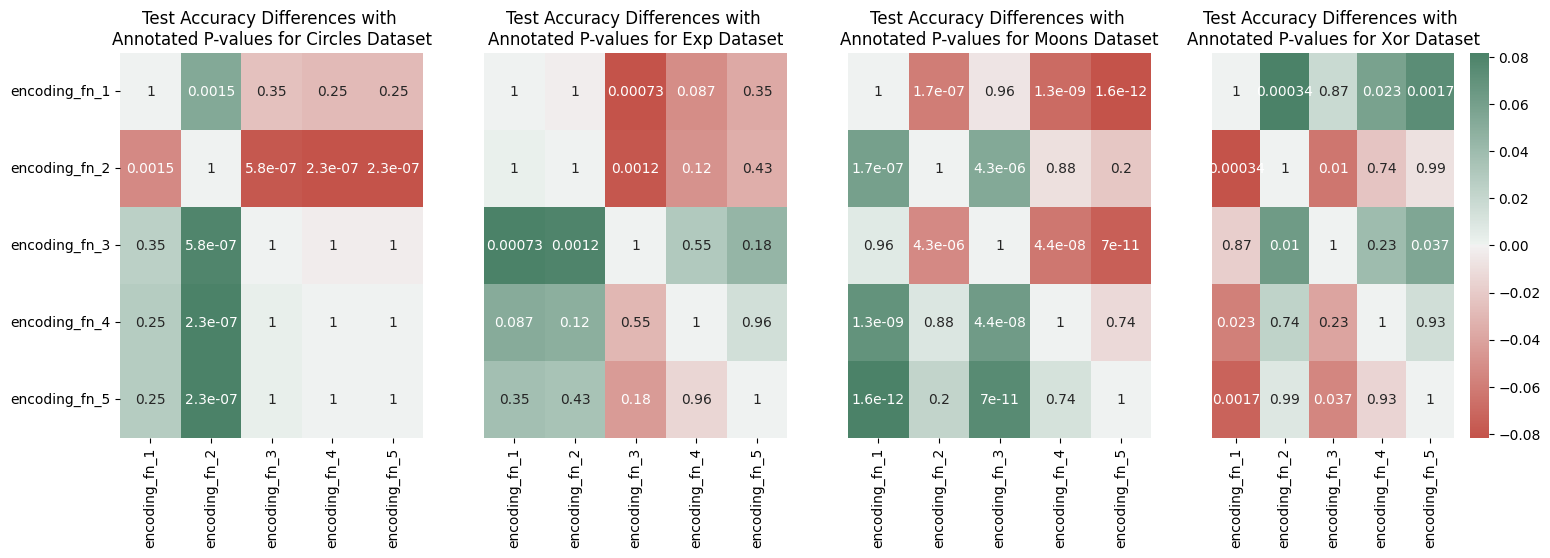

In [17]:
import seaborn as sns

# plot the pvalues of the pairwise comparisons of feature maps for only the significant ANOVA datasets
num_sig_datasets = np.sum(anova_results_df['Significant?'])
fig, axs = plt.subplots(nrows=1, ncols=num_sig_datasets, figsize=(18, 5))

i = 0
for dataset in DATASET_NAMES:
    if anova_results_df.loc[dataset]['Significant?']:
        # First, calculate the differences in the mean test accuracies scored between all feature maps
        fm_results = results_ds.test.sel(dataset=dataset).mean('cv_id').values
        acc_diffs = -1*np.subtract(*np.meshgrid(fm_results, fm_results))

        # Next, calculate the pairwise significances in those differences using Tukey's HSD test
        samples = [results_ds.test.sel(dataset=dataset, feature_map=feature_map) for feature_map in list(encoding_fns.keys())]
        pvals_matrix = ss.tukey_hsd(*samples).pvalue

        sns.heatmap(
            acc_diffs,
            annot=pvals_matrix,
            ax=axs[i],
            xticklabels=encoding_fns.keys(),
            yticklabels=encoding_fns.keys() if i == 0 else [],
            cbar= True if i == num_sig_datasets-1 else False,
            cmap=sns.diverging_palette(15, 150, s=60, as_cmap=True),
            center=0
        )
        axs[i].set_title(f"Test Accuracy Differences with \nAnnotated P-values for {dataset.capitalize()} Dataset")
        i+=1
    
fig.show()

## Minimum Accuracy Calculation By Pauli Decomposition 

This next section is going to replicate the minimum accuracy calculation procedure described in [1] which takes all the data encoded quantum states and represents them by a Pauli decomposition. I have done this two different, equivalent ways to verify the calculations. The first method will use the datapoints and the feature map to get the state vector, convert it to a density operator, and then apply a Pauli decomposition to get the coefficients for each axis. The second method simply uses table 1 in [1] to calculate the coefficients as functions of x. Both produce the same values but the second method is computationally faster.

In [18]:
from collections import OrderedDict
from qiskit.quantum_info import DensityMatrix, SparsePauliOp, Statevector

def convert_to_pauli_decomposition_old(
        ds: np.ndarray, feature_map: PauliFeatureMap
    ) -> Tuple[np.ndarray, List[str]]:
    """
    Given a dataset of shape (M x N) where M is the number of samples and
    N is the number of features, this function returns a 2D array of the
    quantum representation of the dataset given a feature map. This
    representation first computes the state vector of the data-encoded
    quantum state for each data point, then it converts to the density
    matrix representation, and lastly it converts to a sparse Pauli basis
    representation. For 2-qubits, there are 16 axes so the returned quantum
    dataset will be of shape (M x 16) where each datapoint (row) will have
    16 values corresponding to the 16 coefficients in this feature space.

    Args:
        ds (np.ndarray): classical dataset
        feature_map (PauliFeatureMap): feature map to encode the classical
            datapoints to a quantum state

    Returns:
        np.ndarray: quantum Pauli decomposition representation of dataset
        List[str]: Pauli basis axes
    """

    quantum_ds = np.empty((ds.shape[0], 16))
    pauli_axes = [
        'II', 'XI', 'YI', 'ZI', 'IX', 'XX', 'YX', 'ZX', 'IY', 'XY', 'YY', 'ZY', 'IZ', 'XZ', 'YZ','ZZ'
    ]

    for datapoint_idx, datapoint in enumerate(ds):
        # First, get the state vector of our encoded datapoint
        qc = feature_map.bind_parameters(datapoint)
        state_vector = Statevector.from_instruction(qc)

        # Convert the state vector to a density matrix
        density_matrix = DensityMatrix(state_vector)

        # Then decompose the matrix by the Pauli matrices
        pauli_decomp = SparsePauliOp.from_operator(density_matrix)

        # Lastly, construct full representation
        full_pauli_decomp = OrderedDict(zip(pauli_axes, [0.0]*len(pauli_axes)))
        full_pauli_decomp.update(dict(pauli_decomp.to_list()))

        quantum_ds[datapoint_idx][:] = np.array(list(full_pauli_decomp.values()))

    return quantum_ds, pauli_axes

In [19]:
from numpy import sin, cos

coefficients = {
    'II': lambda x1, x2, x12: np.ones_like(x12)*1/4,
    'XI': lambda x1, x2, x12: (sin(x2)*(sin(x1)*sin(x12)**2 + sin(x2)*cos(x12)**2 + cos(x1)*cos(x2)*sin(x12)))/4,
    'YI': lambda x1, x2, x12: (-sin(x1)*cos(x2)*sin(x12)**2 - sin(x2)*cos(x2)*cos(x12)**2 + cos(x1)*sin(x12)*sin(x2)**2)/4,
    'ZI': lambda x1, x2, x12: cos(x2)*cos(x12)/4,
    'IX': lambda x1, x2, x12: (sin(x1)*(sin(x2)*sin(x12)**2 + sin(x1)*cos(x12)**2 + cos(x2)*cos(x1)*sin(x12)))/4,
    'XX': lambda x1, x2, x12: ((sin(x1)**2)*(sin(x2)**2) + sin(x12)*cos(x1)*cos(x2)*(sin(x1)+sin(x2)))/4,
    'YX': lambda x1, x2, x12: ((-sin(x1)**2)*sin(x2)*cos(x2) + sin(x12)*cos(x1)*(sin(x1)*sin(x2) - cos(x2)**2))/4,
    'ZX': lambda x1, x2, x12: (cos(x12)*(-sin(x2)*cos(x1)*sin(x12) + cos(x2)*sin(x1)**2 + sin(x1)*cos(x1)*sin(x12)))/4,
    'IY': lambda x1, x2, x12: (-sin(x2)*cos(x1)*sin(x12)**2 - sin(x1)*cos(x1)*cos(x12)**2 + cos(x2)*sin(x12)*sin(x1)**2)/4,
    'XY': lambda x1, x2, x12: ((-sin(x2)**2)*sin(x1)*cos(x1) + sin(x12)*cos(x2)*(sin(x1)*sin(x2) - cos(x1)**2))/4,
    'YY': lambda x1, x2, x12: (sin(x1)*cos(x1)*sin(x2)*cos(x2) - sin(x12)*((cos(x2)**2)*sin(x1) + sin(x2)*cos(x1)**2))/4,
    'ZY': lambda x1, x2, x12: (sin(x1)*(-sin(x2)*sin(x12)*cos(x12) - cos(x1)*cos(x2)*cos(x12) + sin(x1)*cos(x12)*sin(x12)))/4,
    'IZ': lambda x1, x2, x12: cos(x1)*cos(x12)/4,
    'XZ': lambda x1, x2, x12: (cos(x12)*(-sin(x1)*cos(x2)*sin(x12) + cos(x1)*sin(x2)**2 + sin(x2)*cos(x2)*sin(x12)))/4,
    'YZ': lambda x1, x2, x12: (sin(x2)*(-sin(x1)*sin(x12)*cos(x12) - cos(x2)*cos(x1)*cos(x12) + sin(x2)*cos(x12)*sin(x12)))/4,
    'ZZ': lambda x1, x2, x12: cos(x1)*cos(x2)/4
}

def convert_to_pauli_decomposition(ds: np.ndarray, encoding_fn: Callable) -> Tuple[np.ndarray, List[str]]:
    """
    Given a dataset of shape (M x N) where M is the number of samples and
    N is the number of features, this function returns a 2D array of the
    quantum representation of the dataset given a feature map. This
    representation first computes the state vector of the data-encoded
    quantum state for each data point, then it converts to the density
    matrix representation, and lastly it converts to a sparse Pauli basis
    representation. For 2-qubits, there are 16 axes so the returned quantum
    dataset will be of shape (M x 16) where each datapoint (row) will have
    16 values corresponding to the 16 coefficients in this feature space.

    Args:
        ds (np.ndarray): classical dataset
        feature_map (PauliFeatureMap): feature map to encode the classical
            datapoints to a quantum state

    Returns:
        np.ndarray: quantum Pauli decomposition representation of dataset
        List[str]: Pauli basis axes
    """
    x1, x2 = np.hsplit(ds, 2)
    x3 = encoding_fn(x1, x2)

    return np.hstack([fn(x1, x2, x3) for fn in coefficients.values()]), list(coefficients.keys())

In [20]:
# Test that both methods produce the same quantum representation of the dataset to verify methodology
np.testing.assert_allclose(
    convert_to_pauli_decomposition_old(toy_dataset['circles']['X'], param_circuit(encoding_fns['encoding_fn_1']))[0],
    convert_to_pauli_decomposition(toy_dataset['circles']['X'], encoding_fns['encoding_fn_1'])[0]
)

In [21]:
# Now implement a scoring function for the minimum accuracy calculation
def compute_accuracy(labels_ordered: np.ndarray, threshold_idx: int) -> float:
    """
    Given the ordered list of labels, compute the accuracy
    where the desired pattern is all labels of 1 fall on the left
    side of the threshold index and all labels of 0 fall on the right
    side of the threshold index. This accuracy calculation comes from
    equation 7 in [1].

    Args:
        labels_ordered (np.ndarray): list of ordered labels
        threshold_idx (int): threshold of classification boundary

    Returns:
        float: accuracy, in range 0-1.0
    """
    n = labels_ordered.shape[0]
    labels_left = labels_ordered[0: threshold_idx]
    n_plus = np.sum(labels_left == 1)
    n_minus = np.sum(labels_left == 0)

    return (1/n)*(max(n_plus, n_minus) + (n/2)  - min(n_plus,  n_minus))


In [22]:
cv_num = 30

# Define all the settings for running this exactly as the paper (except random seeds)
training_pct = 0.5
N = 40
c = 10e10 # this implements hard-margin SVM but could be overfitting
data_seed = 112120231
sampler_seed = 112120232
shots = 10000
backend='qasm_simulator'

In [23]:
import xarray as xr
from data_processing import make_datasets

# Store results
min_test_accuracy = np.empty((cv_num, len(DATASET_NAMES), len(encoding_fns)))
min_test_accuracy_axis = np.chararray((cv_num, len(DATASET_NAMES), len(encoding_fns)), itemsize=2)

# Use same number of cross validations and random seeds as above so we can compare
for cv_id in np.arange(cv_num):
    datasets = make_datasets(n_samples=N, training_pct=training_pct, seed=data_seed+cv_id)
    for ef_idx, encoding_fn in enumerate(encoding_fns.values()):
        for ds_idx, dataset in enumerate(datasets):
            quantum_ds, pauli_axes = convert_to_pauli_decomposition(
                datasets[dataset]['train']['X'], encoding_fn=encoding_fn
            )

            labels = datasets[dataset]['train']['y']
            n_samples, n_quantum_dims =  quantum_ds.shape

            max_acc = 0.0
            max_acc_axis_idx = 0

            for j in np.arange(n_quantum_dims):
                labels_ordered = np.take(labels, np.argsort(quantum_ds[:, j].squeeze()))
                acc = max([compute_accuracy(labels_ordered, threshold_idx=i) for i in range(n_samples+1)])
                if acc > max_acc:
                    max_acc = acc
                    max_acc_axis_idx = j


            min_test_accuracy[cv_id][ds_idx][ef_idx] = max_acc
            min_test_accuracy_axis[cv_id][ds_idx][ef_idx] = pauli_axes[max_acc_axis_idx]


min_test_accuracy_ds = xr.Dataset(
    data_vars={
        "accuracy":(["cv_id", "dataset", "feature_map"], min_test_accuracy),
        "axis": (["cv_id", "dataset", "feature_map"], min_test_accuracy_axis)
    },
    coords={"cv_id": np.arange(cv_num), "dataset": DATASET_NAMES, "feature_map": list(encoding_fns.keys())}
).transpose("cv_id", "feature_map", "dataset")

In [24]:
min_test_accuracy_ds.accuracy.mean('cv_id').to_pandas()

dataset,circles,exp,moons,xor
feature_map,,,,
encoding_fn_1,1.0,0.848333,0.848333,0.968333
encoding_fn_2,1.0,0.845000,0.845000,0.926667
encoding_fn_3,1.0,0.950000,0.895000,0.898333
encoding_fn_4,1.0,0.898333,0.898333,0.861667
encoding_fn_5,1.0,0.880000,0.900000,0.878333


In [25]:
results_ds.test.mean('cv_id').to_pandas()

dataset,circles,exp,moons,xor
feature_map,,,,
encoding_fn_1,0.938333,0.786667,0.683333,0.930000
encoding_fn_2,0.871667,0.790000,0.830000,0.848333
encoding_fn_3,0.970000,0.893333,0.700000,0.911667
encoding_fn_4,0.973333,0.853333,0.853333,0.871667
encoding_fn_5,0.973333,0.835000,0.883333,0.856667


The paper states that the minimum accuracy value should be a lower bound on the training accuracy achievable of the SVM because the calculation assumes a hard-margin SVM but selects only a single Pauli axis to linearly separate the data. It represents a worse-case scenario but since our SVM 100% training accuracy, there's not too much we can verify because the training accuracies would never fall below a theoretical lower bound. This also means we can't verify the claim that this calculation can help screen candidate feature maps since we have no correlation between the minimum training accuracy and the actual training accuracies.

However, if we compare to the test accuracies (which isn't apples-to-apples), we can see that the encoding functions that have the highest minimum accuracy for each dataset tend to have the highest actual accuracies of our test dataset, with exception to the circles dataset. So this might mean that we can still use it as an indicator of which feature map candidate could perform the best.

## Color Maps

In the minimum training accuracy calculation above, I grabbed not only the score but I also recorded the specific Pauli axis that linearly separated the data the best. Let's take a look at those axes now and see if they support the claim that feature maps that have patterns that resemble the shapes of the dataset will be more successful. The heatmap plots below are reproduced from the paper (figures 6-10 in [1]) which show the values of coefficients of the pauli matrix decompositions of $\phi_{1, 2}(\bm{x})$ for the different encoding functions.

In [26]:
x1s = np.linspace(-1, 1, 100)
x2s = np.linspace(-1, 1, 100)
x1s_grid, x2s_grid = np.meshgrid(x1s, x2s)

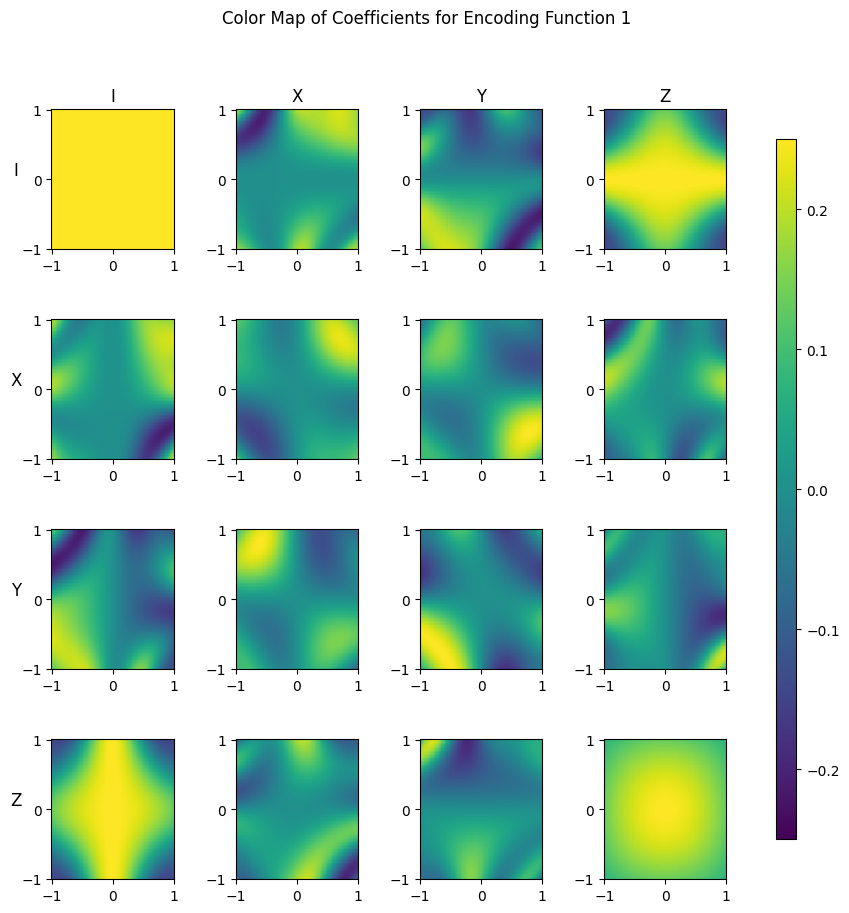

In [27]:
# Feature Map 1
fm1_x12s_grid = encoding_fns['encoding_fn_1'](x1s_grid, x2s_grid)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i in np.arange(4):
    for j in np.arange(4):
        idx = i*4 + j
        pauli_matrix = list(coefficients.keys())[idx]
        aixs = coefficients[pauli_matrix](x1s_grid, x2s_grid, fm1_x12s_grid)
        heatmap = axs[i, j].pcolor(x1s, x2s, aixs, vmin=-0.25, vmax=0.25)
        axs[i, j].set_xticks([-1, 0, 1])
        axs[i, j].set_yticks([-1, 0, 1])

        # Set some grid axes up
        if i == 0:
            axs[i, j].set_title(pauli_matrix[0])
        if j == 0:
            axs[i, j].set_ylabel(pauli_matrix[1], rotation=0, size='large')

fig.subplots_adjust(right=0.8, wspace=0.5, hspace=0.5)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(heatmap, cax=cbar_ax)
fig.suptitle('Color Map of Coefficients for Encoding Function 1')


plt.show()


In [28]:
from collections import Counter

# Get the counts of the best axis to linearly separate data for each dataset

for dataset in DATASET_NAMES:
    counts = Counter(min_test_accuracy_ds.axis.sel(dataset=dataset, feature_map='encoding_fn_1').values)
    test_acc = results_ds.test.mean('cv_id').sel(dataset=dataset, feature_map='encoding_fn_1').values
    print(f"{dataset} ({np.round(test_acc*100, decimals=2)}%)\t: {counts}")


circles (93.83%)	: Counter({b'ZZ': 20, b'IZ': 6, b'ZI': 4})
exp (78.67%)	: Counter({b'YI': 8, b'ZY': 7, b'IY': 3, b'XZ': 3, b'YZ': 2, b'YX': 2, b'IX': 1, b'XX': 1, b'YY': 1, b'ZZ': 1, b'ZX': 1})
moons (68.33%)	: Counter({b'IX': 8, b'IY': 8, b'YZ': 7, b'XI': 5, b'ZX': 1, b'XX': 1})
xor (93.0%)	: Counter({b'YX': 26, b'XY': 3, b'YI': 1})


First, we can observe that the datasets for which this encoding function scores higher has less amiguous results for the best axis. For example, the best scoring dataset (xor) selects the YX axis most of the time which means that it clearly is an important feature. Similarly, we see the circles dataset selecting the ZZ axis 20 out of the 30 times. However, for the exponential and moons dataset, there is much more a mix of axes selected which might suggest there isn't a clear winner of axis in the feature space that does well for this dataset. 

Furthermore, in the case of the XOR dataset, when we look at the YX axis above, we do see shapes that resemble the dataset's patterns which support the claims of the authors in [1]. We see the same thing for theh circles dataset with it selecting ZZ and IZ/ZI which both have circular shapes.

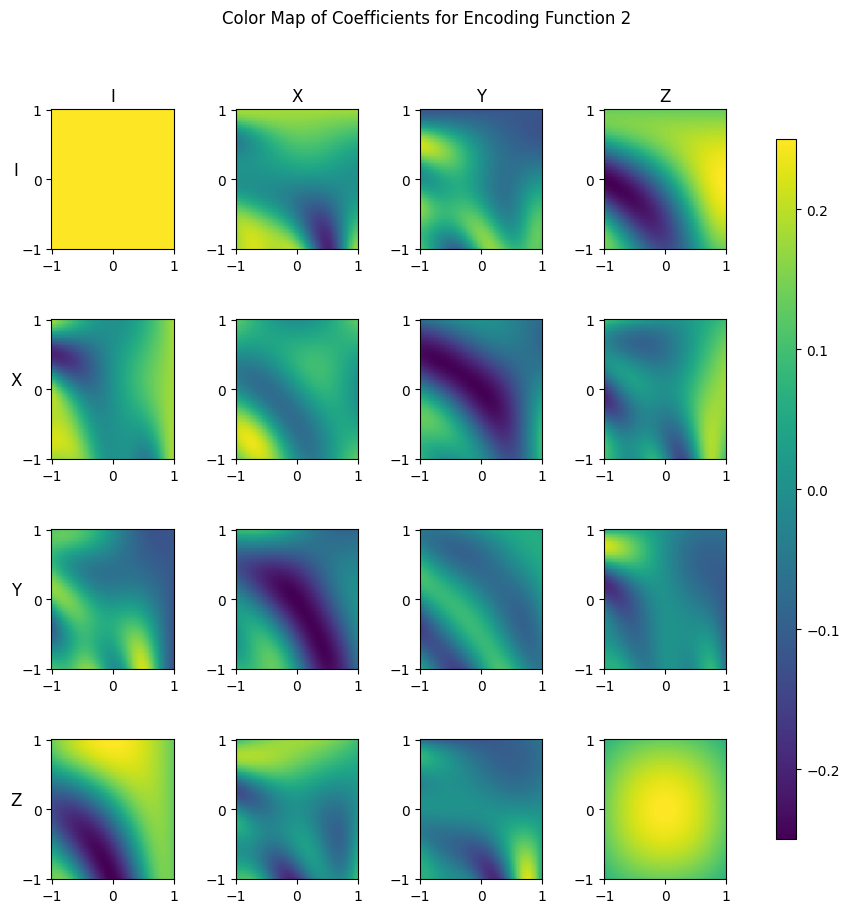

In [29]:
# Feature Map 2
fm2_x12s_grid = encoding_fns['encoding_fn_2'] (x1s_grid, x2s_grid)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i in np.arange(4):
    for j in np.arange(4):
        idx = i*4 + j
        pauli_matrix = list(coefficients.keys())[idx]
        aixs = coefficients[pauli_matrix](x1s_grid, x2s_grid, fm2_x12s_grid)
        heatmap = axs[i, j].pcolor(x1s, x2s, aixs, vmin=-0.25, vmax=0.25)
        axs[i, j].set_xticks([-1, 0, 1])
        axs[i, j].set_yticks([-1, 0, 1])

        # Set some grid axes up
        if i == 0:
            axs[i, j].set_title(pauli_matrix[0])
        if j == 0:
            axs[i, j].set_ylabel(pauli_matrix[1], rotation=0, size='large')

fig.subplots_adjust(right=0.8, wspace=0.5, hspace=0.5)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(heatmap, cax=cbar_ax)
fig.suptitle('Color Map of Coefficients for Encoding Function 2')


plt.show()

In [30]:
# Get the counts of the best axis to linearly separate data for each dataset

for dataset in DATASET_NAMES:
    counts = Counter(min_test_accuracy_ds.axis.sel(dataset=dataset, feature_map='encoding_fn_2').values)
    test_acc = results_ds.test.mean('cv_id').sel(dataset=dataset, feature_map='encoding_fn_2').values
    print(f"{dataset} ({np.round(test_acc*100, decimals=2)}%)\t: {counts}")

circles (87.17%)	: Counter({b'ZZ': 30})
exp (79.0%)	: Counter({b'IY': 8, b'YI': 5, b'IX': 4, b'IZ': 3, b'XZ': 3, b'ZX': 2, b'ZY': 1, b'YZ': 1, b'XI': 1, b'ZZ': 1, b'XY': 1})
moons (83.0%)	: Counter({b'XI': 14, b'YI': 6, b'XZ': 5, b'XX': 3, b'YY': 2})
xor (84.83%)	: Counter({b'YZ': 6, b'IX': 6, b'YX': 5, b'ZY': 5, b'XY': 3, b'XI': 2, b'XX': 2, b'YI': 1})


Overall, the "best" axis for each dataset is much more amiguous for this encoding function with exception to the circles dataset which again selects ZZ most of the time. However, it has less success here as it did in the encoding function above.

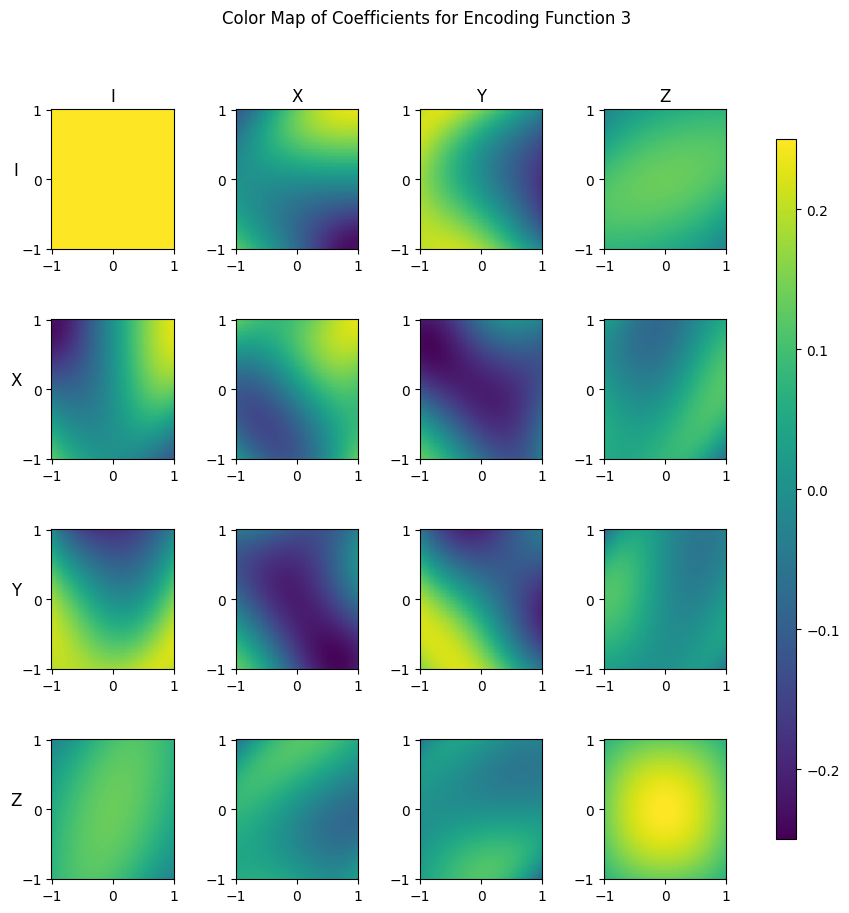

In [31]:
# Feature Map 3
fm3_x12s_grid = encoding_fns['encoding_fn_3'] (x1s_grid, x2s_grid)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i in np.arange(4):
    for j in np.arange(4):
        idx = i*4 + j
        pauli_matrix = list(coefficients.keys())[idx]
        aixs = coefficients[pauli_matrix](x1s_grid, x2s_grid, fm3_x12s_grid)
        heatmap = axs[i, j].pcolor(x1s, x2s, aixs, vmin=-0.25, vmax=0.25)
        axs[i, j].set_xticks([-1, 0, 1])
        axs[i, j].set_yticks([-1, 0, 1])

        # Set some grid axes up
        if i == 0:
            axs[i, j].set_title(pauli_matrix[0])
        if j == 0:
            axs[i, j].set_ylabel(pauli_matrix[1], rotation=0, size='large')

fig.subplots_adjust(right=0.8, wspace=0.5, hspace=0.5)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(heatmap, cax=cbar_ax)
fig.suptitle('Color Map of Coefficients for Encoding Function 3')


plt.show()

In [32]:
# Get the counts of the best axis to linearly separate data for each dataset

for dataset in DATASET_NAMES:
    counts = Counter(min_test_accuracy_ds.axis.sel(dataset=dataset, feature_map='encoding_fn_3').values)
    test_acc = results_ds.test.mean('cv_id').sel(dataset=dataset, feature_map='encoding_fn_3').values
    print(f"{dataset} ({np.round(test_acc*100, decimals=2)}%)\t: {counts}")

circles (97.0%)	: Counter({b'ZZ': 21, b'ZI': 5, b'IZ': 3, b'XY': 1})
exp (89.33%)	: Counter({b'ZX': 19, b'YZ': 6, b'IY': 4, b'XZ': 1})
moons (70.0%)	: Counter({b'XI': 12, b'XZ': 6, b'IY': 5, b'ZX': 4, b'YI': 3})
xor (91.17%)	: Counter({b'YX': 11, b'XY': 6, b'ZI': 5, b'XI': 3, b'IX': 2, b'IZ': 2, b'ZY': 1})


This encoding function performs best on the circles dataset and again selects the ZZ axis a majority of the time, same as the other encoding functions. This encoding function also has the highest score for the exponential dataset out of all encoding functions and it seems to select the ZX axis a majority of the time. In the plots above, we can see that the ZX heatmap does produce a line that sits near where the exp dataset line separates the two classes so it would make sense that it would select that axis.

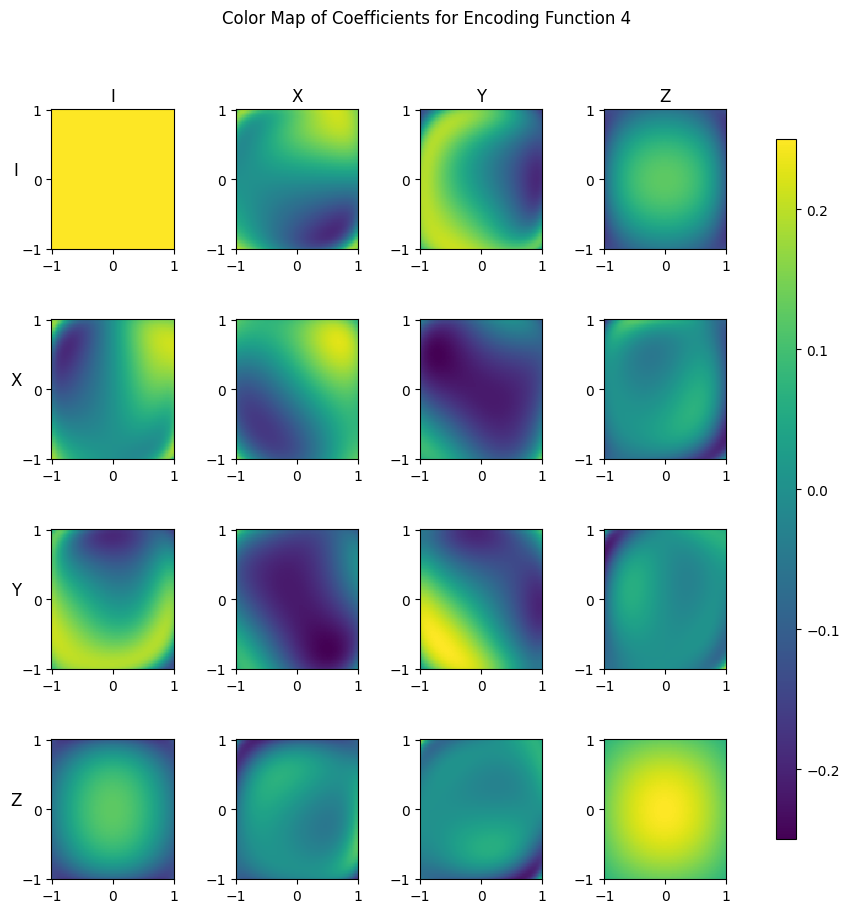

In [33]:
# Feature Map 4
fm4_x12s_grid = encoding_fns['encoding_fn_4'] (x1s_grid, x2s_grid)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i in np.arange(4):
    for j in np.arange(4):
        idx = i*4 + j
        pauli_matrix = list(coefficients.keys())[idx]
        aixs = coefficients[pauli_matrix](x1s_grid, x2s_grid, fm4_x12s_grid)
        heatmap = axs[i, j].pcolor(x1s, x2s, aixs, vmin=-0.25, vmax=0.25)
        axs[i, j].set_xticks([-1, 0, 1])
        axs[i, j].set_yticks([-1, 0, 1])

        # Set some grid axes up
        if i == 0:
            axs[i, j].set_title(pauli_matrix[0])
        if j == 0:
            axs[i, j].set_ylabel(pauli_matrix[1], rotation=0, size='large')

fig.subplots_adjust(right=0.8, wspace=0.5, hspace=0.5)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(heatmap, cax=cbar_ax)
fig.suptitle('Color Map of Coefficients for Encoding Function 4')


plt.show()

In [34]:
# Get the counts of the best axis to linearly separate data for each dataset

for dataset in DATASET_NAMES:
    counts = Counter(min_test_accuracy_ds.axis.sel(dataset=dataset, feature_map='encoding_fn_4').values)
    test_acc = results_ds.test.mean('cv_id').sel(dataset=dataset, feature_map='encoding_fn_4').values
    print(f"{dataset} ({np.round(test_acc*100, decimals=2)}%)\t: {counts}")

circles (97.33%)	: Counter({b'ZI': 29, b'IZ': 1})
exp (85.33%)	: Counter({b'IY': 21, b'XI': 5, b'YI': 1, b'YX': 1, b'IX': 1, b'ZY': 1})
moons (85.33%)	: Counter({b'XI': 18, b'IY': 7, b'ZY': 4, b'XZ': 1})
xor (87.17%)	: Counter({b'YX': 13, b'XY': 7, b'XI': 5, b'IX': 2, b'XX': 2, b'IZ': 1})


This encoding function selects the ZI axis for the circles dataset most of the time which is different than the other encoding functions which always select ZZ.

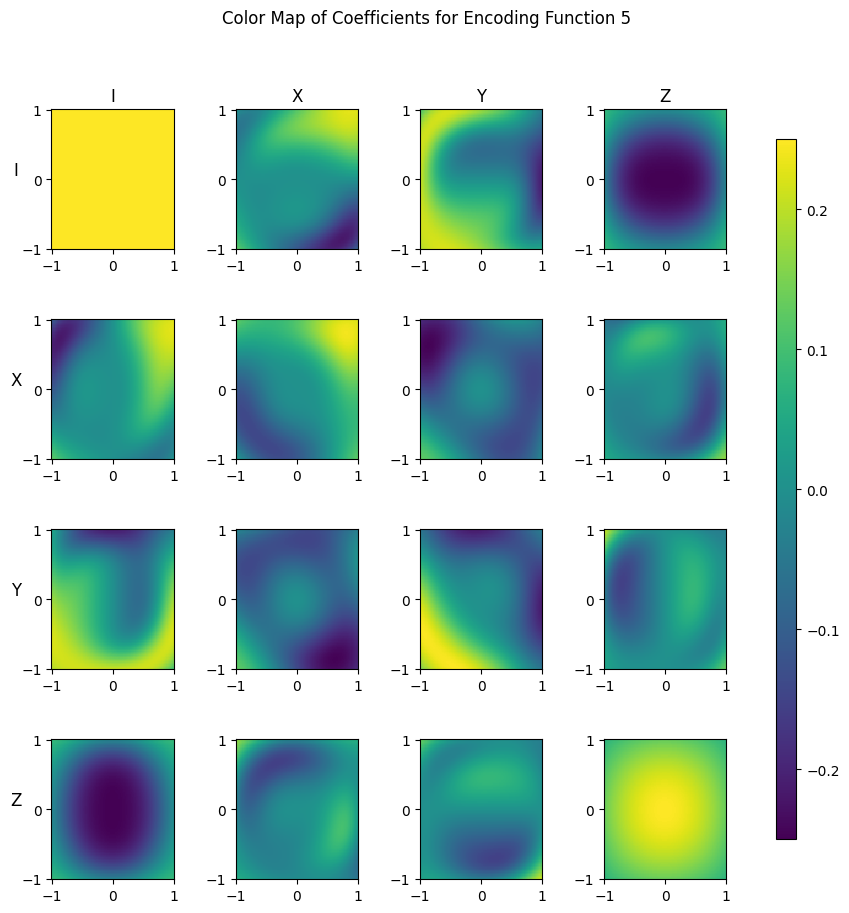

In [35]:
# Feature Map 5
fm5_x12s_grid = encoding_fns['encoding_fn_5'] (x1s_grid, x2s_grid)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i in np.arange(4):
    for j in np.arange(4):
        idx = i*4 + j
        pauli_matrix = list(coefficients.keys())[idx]
        aixs = coefficients[pauli_matrix](x1s_grid, x2s_grid, fm5_x12s_grid)
        heatmap = axs[i, j].pcolor(x1s, x2s, aixs, vmin=-0.25, vmax=0.25)
        axs[i, j].set_xticks([-1, 0, 1])
        axs[i, j].set_yticks([-1, 0, 1])

        # Set some grid axes up
        if i == 0:
            axs[i, j].set_title(pauli_matrix[0])
        if j == 0:
            axs[i, j].set_ylabel(pauli_matrix[1], rotation=0, size='large')

fig.subplots_adjust(right=0.8, wspace=0.5, hspace=0.5)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(heatmap, cax=cbar_ax)
fig.suptitle('Color Map of Coefficients for Encoding Function 5')


plt.show()

In [36]:
# Get the counts of the best axis to linearly separate data for each dataset

for dataset in DATASET_NAMES:
    counts = Counter(min_test_accuracy_ds.axis.sel(dataset=dataset, feature_map='encoding_fn_5').values)
    test_acc = results_ds.test.mean('cv_id').sel(dataset=dataset, feature_map='encoding_fn_5').values
    print(f"{dataset} ({np.round(test_acc*100, decimals=2)}%)\t: {counts}")

circles (97.33%)	: Counter({b'ZI': 29, b'IZ': 1})
exp (83.5%)	: Counter({b'IY': 7, b'ZX': 6, b'XI': 6, b'XZ': 3, b'XX': 3, b'ZY': 3, b'YZ': 1, b'YY': 1})
moons (88.33%)	: Counter({b'IY': 9, b'ZX': 8, b'XZ': 4, b'XI': 4, b'IX': 3, b'YZ': 1, b'YI': 1})
xor (85.67%)	: Counter({b'YX': 15, b'XY': 7, b'IX': 3, b'XI': 3, b'ZY': 1, b'XX': 1})


Same as above, the circles dataset selects the ZI axis a majority of the time for this encoding function. This function performs best on the moons dataset and it selects IY and ZX most of the time as the best axis, which have crescent-like patterns as shown in the plots above.

## Color Maps - Part 2

One question that popped up was regarding the feature maps that the authors used. Specifically, they did not scale their data $x_1, x_2 \in [-1, 1]$ to cover the full range of rotation which is $-\pi to +\pi$. The trig functions in the $\phi_{1,2}(\vec{x})$ functions also were not treated to have scaled inputs so these values are also truncated from the full range of the encoding functions. The question is then how does this impact the quantum feature space. If the inputs were appropriately scaled, how would the color maps change?

In [38]:
from itertools import product

x1s = np.linspace(-1, 1, 100)*np.pi
x2s = np.linspace(-1, 1, 100)*np.pi
ds = np.array(list(product(x1s, x2s)))

INFO:root:computing coefficients for 0
INFO:root:computing coefficients for 1
INFO:root:computing coefficients for 2
INFO:root:computing coefficients for 3
INFO:root:computing coefficients for 4
INFO:root:computing coefficients for 5
INFO:root:computing coefficients for 6
INFO:root:computing coefficients for 7
INFO:root:computing coefficients for 8
INFO:root:computing coefficients for 9
INFO:root:computing coefficients for 10
INFO:root:computing coefficients for 11
INFO:root:computing coefficients for 12
INFO:root:computing coefficients for 13
INFO:root:computing coefficients for 14
INFO:root:computing coefficients for 15


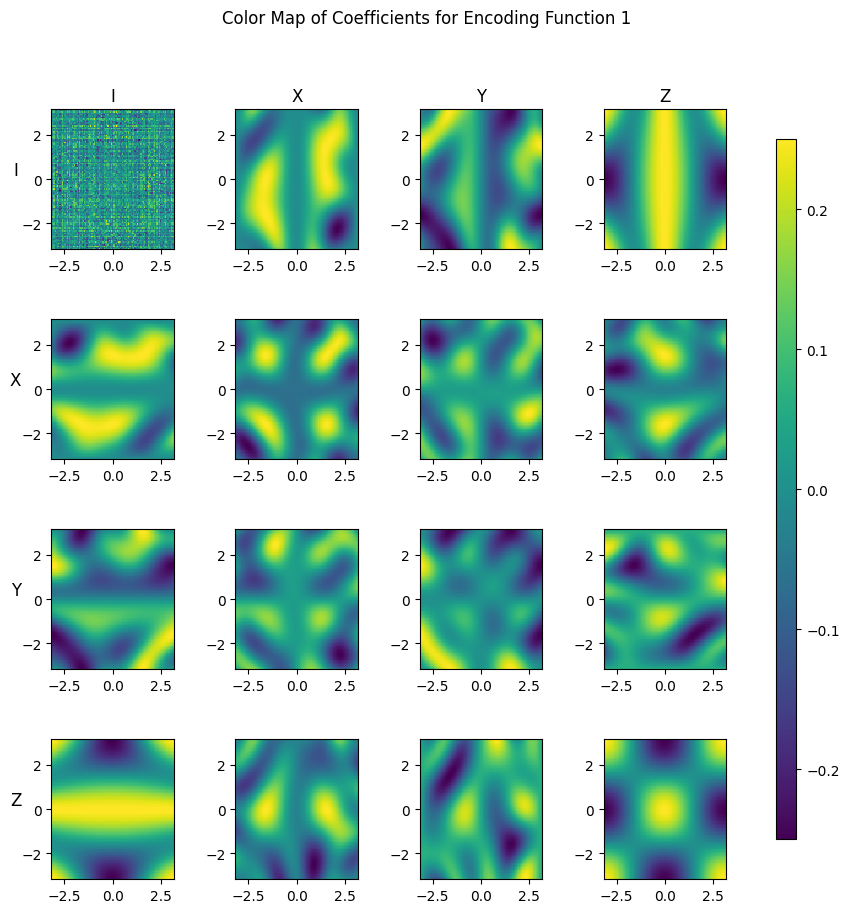

In [39]:
# Feature Map 1
from qiskit.circuit.library import PauliFeatureMap
from minimum_accuracy import compute_pauli_decomposition

def data_map_func(x):
    coeff = x[0] if len(x) == 1 else np.pi*(x[0]/(np.pi))*(x[1]/(np.pi))
    return coeff
    
fm = PauliFeatureMap(feature_dimension=2, reps=2, entanglement='linear', alpha=1.0, data_map_func=data_map_func)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i in np.arange(4):
    for j in np.arange(4):
        idx = i*4 + j
        logger.info(f"computing coefficients for {idx}")
        pauli_matrix = list(coefficients.keys())[idx]
        aixs = compute_pauli_decomposition(ds=ds, feature_map=fm, axes=[idx])
        heatmap = axs[i, j].pcolor(x1s, x2s, aixs.reshape(100, 100))

        # Set some grid axes up
        if i == 0:
            axs[i, j].set_title(pauli_matrix[0])
        if j == 0:
            axs[i, j].set_ylabel(pauli_matrix[1], rotation=0, size='large')

fig.subplots_adjust(right=0.8, wspace=0.5, hspace=0.5)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(heatmap, cax=cbar_ax)
fig.suptitle('Color Map of Coefficients for Encoding Function 1')


plt.show()

These patterns look a bit more similar to the adhoc dataset generated by sampling a ZZFeatureMap shown here: https://qiskit.org/ecosystem/machine-learning/tutorials/03_quantum_kernel.html. Thus I imagine that the truncated values that the authors use generate maps that are quite a bit simpler due to their _expressibiility_ (ability to reach everywhere on the Bloch sphere) being lower than the feature map above which scales the data to cover the full domain.

## References

1. https://arxiv.org/pdf/1906.10467.pdf